In [45]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Input,Dense,Dropout,Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont,ImageDraw
import random

In [27]:
def create_pair(x,digit_indices):
    '''
    Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min(len(digit_indices[d]) for d in range(10)) -1
    for d in range(10):
        for i in range(n):
            z1,z2 = digit_indices[d][i],digit_indices[d][i+1]
            pairs += [[x[z1],x[z2]]]
            inc = random.randrange(1,10)
            dn = (d + inc) % 10
            z1,z2 = digit_indices[d][i],digit_indices[dn][i]
            pairs += [[x[z1],x[z2]]]
            labels += [1,0]
    return np.array(pairs),np.array(labels)
def create_pairs_on_set(images,labels):
    digit_indices = [np.where(labels==i)[0] for i in range(10)]
    pairs,y=create_pair(images,digit_indices)
    y = y.astype('float32')
    return pairs,y

In [28]:
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()

In [29]:
train_images = train_images.astype('float32')/255
test_images = test_images.astype('float32')/255
tr_pairs,tr_y=create_pairs_on_set(train_images,train_labels)
ts_pairs,ts_y=create_pairs_on_set(test_images,test_labels)

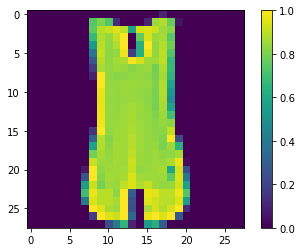

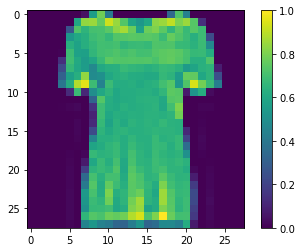

1.0


In [32]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()
this_pair = 4
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])
print(tr_y[this_pair])

In [35]:
def initialize_base_network():
    input = Input(shape=(28,28,),name='base_input')
    x = Flatten(name='flatten_input')(input)
    x = Dense(128,activation='relu',name='first_base_dense')(x)
    x = Dropout(0.1,name='first_dropout')(x)
    x = Dense(128,activation='relu',name='second_base_dense')(x)
    x = Dropout(0.1,name='second_dropout')(x)
    x = Dense(128,activation='relu',name='third_base_dense')(x)
    return Model(inputs=input,outputs=x)
def euclidean_distance(vects):
    x,y=vects
    sum_square = K.sum(K.square(x-y),axis=1,keepdims=True)
    return K.sqrt(K.maximum(sum_square,K.epsilon()))
def eucl_dist_output_shape(shapes):
    shape1,shape2 = shapes
    return (shape1[0],1)

In [46]:
base_network = initialize_base_network()
plot_model(base_network,show_shapes=True,show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [42]:
input_a = Input(shape=(28,28,),name='left_input')
vect_output_a = base_network(input_a)
input_b = Input(shape=(28,28,),name='right_input')
vect_output_b = base_network(input_b)
output = Lambda(euclidean_distance,name='output_layer',output_shape=eucl_dist_output_shape)([vect_output_a,vect_output_b])
model = Model(inputs=[input_a,input_b],outputs=output)

In [43]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 28, 28)]     0           []                               
                                                                                                  
 right_input (InputLayer)       [(None, 28, 28)]     0           []                               
                                                                                                  
 model_4 (Functional)           (None, 128)          133504      ['left_input[0][0]',             
                                                                  'right_input[0][0]']            
                                                                                                  
 output_layer (Lambda)          (None, 1)            0           ['model_4[0][0]',          

In [50]:
def constrastive_loss_with_margin(margin):
    def contrastive_loss(y_true,y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin-y_pred,0))
        return K.mean(y_true*square_pred + (1-y_true) *margin_square)
    return contrastive_loss

In [57]:
rms = RMSprop()
model.compile(loss=constrastive_loss_with_margin(margin=1),optimizer=rms)
history = model.fit([tr_pairs[:,0],tr_pairs[:,1]],tr_y,epochs=20,batch_size=128,validation_data=([ts_pairs[:,0],ts_pairs[:,1]],ts_y))
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]],y=ts_y)

Epoch 1/20


2022-02-08 17:12:25.803558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.0671

2022-02-08 17:12:37.709593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 13s 13ms/step - loss: 0.0671 - val_loss: 0.0702
Epoch 2/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0639 - val_loss: 0.0664
Epoch 3/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0614 - val_loss: 0.0647
Epoch 4/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0598 - val_loss: 0.0670
Epoch 5/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0583 - val_loss: 0.0661
Epoch 6/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0574 - val_loss: 0.0633
Epoch 7/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0559 - val_loss: 0.0649
Epoch 8/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0551 - val_loss: 0.0645
Epoch 9/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0542 - val_loss: 0.0642
Epoch 10/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0534 - val_los

In [58]:
def accuracy(y_true,y_pred):
    pred = y_pred.ravel()>0.5
    return np.mean(pred==y_true)

In [59]:
y_pred_train = model.predict([tr_pairs[:,0],tr_pairs[:,1]])
train_accuracy = accuracy(tr_y,y_pred_train)
y_pred_test = model.predict([ts_pairs[:,0],ts_pairs[:,1]])
test_accuracy = accuracy(ts_y,y_pred_test)
print('Loss = {}, Train accuracy = {}, Test accuracy = {}'.format(loss,train_accuracy,test_accuracy))

2022-02-08 17:19:28.643799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Loss = 0.05970846489071846, Train accuracy = 0.05430071678613102, Test accuracy = 0.07982982982982983
